Install required libraries

In [1]:
# Install required Python packages
%pip install pandas openpyxl nltk zemberek-python scikit-learn JPype1 xgboost lightgbm imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


Import libraries

In [2]:
# Import necessary libraries
import jpype
from jpype import JClass
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import multiprocessing
import pickle
import os
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load and Clean Data

In [3]:
# Load and clean the Troff dataset
df_troff = pd.read_csv("../data/raw/troff-v1.0.tsv", sep="\t")
df_troff['text'] = df_troff['text'].str.replace('\n', ' ').str.replace('\r', ' ')
# save to a CSV file for further use
df_troff[['text', 'label']].to_csv("../data/troff-v1.0-refined.csv", index=False)

# Load the Turkish Hate Speech dataset
df_turkish = pd.ExcelFile("../data/raw/Türkçe Nefret Söylemi Veriseti.xlsx")
# omit the first sheet which contains numerical informations from each sheet
df_turkish_sheet_names = df_turkish.sheet_names[1:]
column_names = ["text", "label"]
combined_df = pd.DataFrame(columns=column_names)

# Combine sheets into a single DataFrame
for sheet_name in df_turkish_sheet_names:
    # first two rows are headers, the second and third columns are the text and label columns
    df = pd.read_excel(df_turkish, sheet_name=sheet_name, skiprows=2, usecols="B:C", header=None)
    df.columns = column_names 
    # remove newline and carriage return characters to make all texts in a single line
    df['text'] = df['text'].str.replace('\n', ' ').str.replace('\r', ' ')
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# save to a CSV file for further use    
combined_df.to_csv("../data/combined_turkish_hate_speech.csv", index=False)

Explore data

In [4]:
# Load refined datasets
df_troff_refined = pd.read_csv("../data/troff-v1.0-refined.csv")
df_combined_turkish = pd.read_csv("../data/combined_turkish_hate_speech.csv")

df_troff_refined.info()
display(df_troff_refined['label'].value_counts())
display(df_troff_refined.sample(10))

df_combined_turkish.info()
display(df_combined_turkish['label'].value_counts())
display(df_combined_turkish.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35284 entries, 0 to 35283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    35284 non-null  object
 1   label   35284 non-null  object
dtypes: object(2)
memory usage: 551.4+ KB


label
non     28439
ind      3279
grp      1750
prof     1455
oth       361
Name: count, dtype: int64

,text,label
13448,Bundan birkaç hafta önce Müslüm Gürses'in şark...,ind
13811,Günaydın ayıp olmasın diye yaşıyormuş gibi yap...,non
4279,Olabileceğimiz en güzel yer mezarlık ordada ya...,non
21060,Benim anlamadığım sude bu güne kadar emreyle k...,non
14526,bu yaptığın çok ayıp 😡 ne bileyim ben be,ind
31088,+Kendim de bilgisayar muhendisi olmakla berabe...,non
11760,"Canım yandı can yaktım, düştüm düşürdüm, üzüld...",non
13386,"Sevmeler yalan olunca, gitmeler kolay olurmuş",non
25479,@USER07991 @USER13074 Bence kirasını versin so...,non
7823,@USER11521 @USER17657 Vallaha mı. Yemin edin. ...,non


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10224 non-null  object
 1   label   10224 non-null  object
dtypes: object(2)
memory usage: 159.9+ KB


label
hiçbiri      7722
nefret       2336
saldırgan     166
Name: count, dtype: int64

,text,label
6605,ayni gun de hem turk j stan hem de çinli j sta...,hiçbiri
1614,Eğerki sevr uygulanmış olsaydı sevr türkiyesin...,hiçbiri
8514,https://t.co/XPwsTzdLE8 Şu mecrada islam dini...,hiçbiri
3773,Yahudi yerleşimcilerin Batı Şeria’daki ırkçı s...,hiçbiri
7628,"Münafık; kafir, gavur, zındık ve dinsiz'den ço...",nefret
631,Suriyeli bir hastam anlattı bir gün;Iç savaş b...,hiçbiri
8339,Bu fotoğraf 1982 baharında Zürih'te çekildi. ...,nefret
5742,10 Ağustos 2015: Şırnak kent merkezi ve ilçele...,hiçbiri
3894,Hitler Yahudi ırkının nasıl yok olduğunu göste...,hiçbiri
8435,Dış işleri bakanlığı ikili anlaşmalarda Balkan...,hiçbiri


Preprocess and Merge data

In [5]:
# Map labels in the Troff dataset
label_mapping = {'non': 'hiçbiri', 'prof': 'saldırgan', 'grp': 'nefret', 'ind': 'nefret', 'oth': 'nefret'}
df_troff_refined['label'] = df_troff_refined['label'].replace(label_mapping)

print("After mapping")
display(df_troff_refined['label'].value_counts())

# merge and save to a CSV file for further use
pd.concat([df_troff_refined, df_combined_turkish], ignore_index=True).to_csv("../data/merged_hate_speech.csv", index=False)

After mapping


label
hiçbiri      28439
nefret        5390
saldırgan     1455
Name: count, dtype: int64

In [6]:
df_merged = pd.read_csv("../data/merged_hate_speech.csv")

df_merged.info()
display(df_merged['label'].value_counts())
display(df_merged.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45508 entries, 0 to 45507
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    45508 non-null  object
 1   label   45508 non-null  object
dtypes: object(2)
memory usage: 711.2+ KB


label
hiçbiri      36161
nefret        7726
saldırgan     1621
Name: count, dtype: int64

,text,label
0,@USER06095 Hırsız demişken Tuncay sizin şu 1.2...,nefret
1,Ne bileyim sen hastayım deyince bende veterine...,nefret
2,Akşam eve gittiğimizde yorgunluğuma iyi gelece...,nefret
3,Kook’un sesini 18381 kez dinledikten sonra eğe...,saldırgan
4,@USER05270 @USER04816 o macta adam 6 7 tane ne...,nefret
5,#BimVeA101deMazotSatılsın Bim ve a101 kaliteli...,nefret
6,Xiumin tam 1 keş. Ne kadar içiyorsa artık insa...,hiçbiri
7,@USER02584 @USER09450 Kahvehanede çok muhabbet...,nefret
8,@USER04185 Ondan sonra bu sapık adam sikini ba...,nefret
9,"Herkes aşk acısı çeker,herkes ihanete ugrar, h...",saldırgan


Text cleaning

In [7]:
def clean_up_tweet(tweet):
    tweet = re.sub(r'https?://\S+', '', tweet) # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet) # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet) # Remove hashtags
    tweet = re.sub(r'[^\w\s]', '', tweet) # Remove punctuation
    tweet = re.sub(r'\s+', ' ', tweet).strip() # Remove extra white spaces    
    return tweet

# Apply the text cleaning function to the merged dataset
df_merged['text'] = df_merged['text'].apply(clean_up_tweet)
display(df_merged.head(10))

,text,label
0,Hırsız demişken Tuncay sizin şu 1200 bin TLlik...,nefret
1,Ne bileyim sen hastayım deyince bende veterine...,nefret
2,Akşam eve gittiğimizde yorgunluğuma iyi gelece...,nefret
3,Kookun sesini 18381 kez dinledikten sonra eğer...,saldırgan
4,o macta adam 6 7 tane net sut cikartti aksini ...,nefret
5,Bim ve a101 kaliteli ürün satıyor diyen A sala...,nefret
6,Xiumin tam 1 keş Ne kadar içiyorsa artık insan...,hiçbiri
7,Kahvehanede çok muhabbet etmişsinDesteksiz atY...,nefret
8,Ondan sonra bu sapık adam sikini bana sürttü,nefret
9,Herkes aşk acısı çekerherkes ihanete ugrar her...,saldırgan


Encode labels and split data

In [8]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Create a new column 'encoded_label' for storing encoded labels
df_merged['encoded_label'] = label_encoder.fit_transform(df_merged['label'])
display(df_merged.head(10))

,text,label,encoded_label
0,Hırsız demişken Tuncay sizin şu 1200 bin TLlik...,nefret,1
1,Ne bileyim sen hastayım deyince bende veterine...,nefret,1
2,Akşam eve gittiğimizde yorgunluğuma iyi gelece...,nefret,1
3,Kookun sesini 18381 kez dinledikten sonra eğer...,saldırgan,2
4,o macta adam 6 7 tane net sut cikartti aksini ...,nefret,1
5,Bim ve a101 kaliteli ürün satıyor diyen A sala...,nefret,1
6,Xiumin tam 1 keş Ne kadar içiyorsa artık insan...,hiçbiri,0
7,Kahvehanede çok muhabbet etmişsinDesteksiz atY...,nefret,1
8,Ondan sonra bu sapık adam sikini bana sürttü,nefret,1
9,Herkes aşk acısı çekerherkes ihanete ugrar her...,saldırgan,2


Text Processing with Zemberek

In [9]:
# Start JVM for Zemberek
def start_jvm():
    if not jpype.isJVMStarted():
        jpype.startJVM(jpype.getDefaultJVMPath(), '-ea', '-Djava.class.path=../zemberek-full.jar')

def shutdown_jvm():
    if jpype.isJVMStarted():
        jpype.shutdownJVM()

def lemmatize(text, morphology):
    if not text.strip():
        return ""
    analysis = morphology.analyzeAndDisambiguate(text)
    result = analysis.bestAnalysis()
    lemmas = [str(i.getLemmas()[0]) for i in result if i.getLemmas()]
    return ' '.join(lemmas)

# Define a function to preprocess tweets using Zemberek
def preprocess_tweet(text, morphology, stopwords):
    text = lemmatize(text, morphology)
    return ' '.join([word for word in text.split() if word not in stopwords])

start_jvm()

TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()
turkish_stopwords = set(stopwords.words('turkish'))

# Apply preprocessing
df_merged['processed_text'] = df_merged['text'].apply(lambda text: preprocess_tweet(text, morphology, turkish_stopwords))
display(df_merged.head(10))

shutdown_jvm()

I|22:12:23.688|Root lexicon created in 642 ms.                                                                     | DictionarySerializer#getDictionaryItems
I|22:12:23.690|Dictionary generated in 727 ms                                                                      | RootLexicon#defaultBinaryLexicon
I|22:12:24.380|Initialized in 1515 ms.                                                                             | TurkishMorphology#createWithDefaults


,text,label,encoded_label,processed_text
0,Hırsız demişken Tuncay sizin şu 1200 bin TLlik...,nefret,1,hırsız tuncay 1200 bin UNK fatura UNK malum mi...
1,Ne bileyim sen hastayım deyince bende veterine...,nefret,1,bil sen has deyi ben veteriner oku karar ver
2,Akşam eve gittiğimizde yorgunluğuma iyi gelece...,nefret,1,akşam ev git yorgun iyi gel UNK bayan ol ev
3,Kookun sesini 18381 kez dinledikten sonra eğer...,saldırgan,2,UNK ses 18381 dinle sonra devam et ağla göz şi...
4,o macta adam 6 7 tane net sut cikartti aksini ...,nefret,1,UNK adam 6 7 tane net sut UNK akis UNK UNK yad...
5,Bim ve a101 kaliteli ürün satıyor diyen A sala...,nefret,1,UNK a101 kalite ürün sat a salak var ula grama...
6,Xiumin tam 1 keş Ne kadar içiyorsa artık insan...,hiçbiri,0,UNK tam 1 keş kadar iç artık insan UNK şişe nu...
7,Kahvehanede çok muhabbet etmişsinDesteksiz atY...,nefret,1,kahvehane muhabbet UNK UNK sen vekil ön koy am...
8,Ondan sonra bu sapık adam sikini bana sürttü,nefret,1,sonra sapık adam sik ben sürt
9,Herkes aşk acısı çekerherkes ihanete ugrar her...,saldırgan,2,herkes aşk acı UNK ihanet UNK herkes aldat pek...


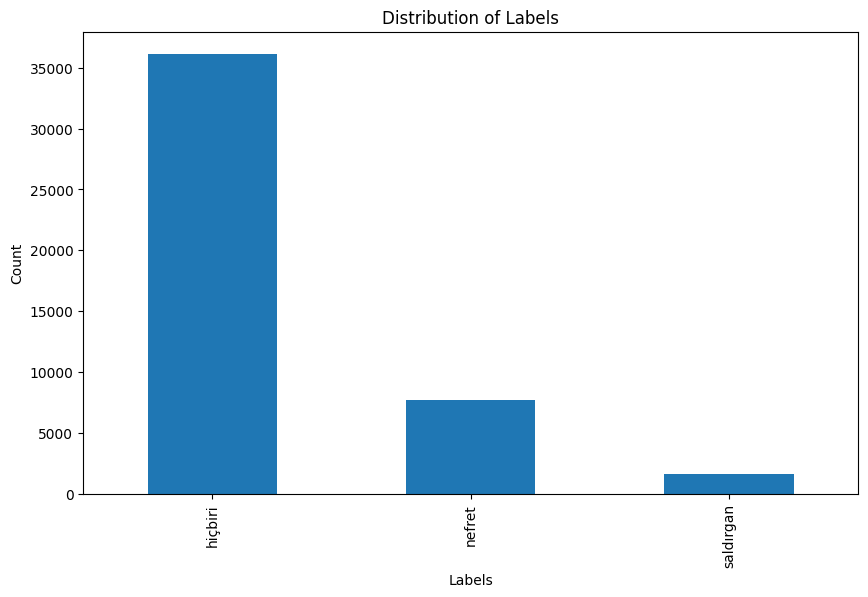

In [ ]:
plt.figure(figsize=(10, 6))
df_merged['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


In [11]:
df_merged

,text,label,encoded_label,processed_text
0,Hırsız demişken Tuncay sizin şu 1200 bin TLlik...,nefret,1,hırsız tuncay 1200 bin UNK fatura UNK malum mi...
1,Ne bileyim sen hastayım deyince bende veterine...,nefret,1,bil sen has deyi ben veteriner oku karar ver
2,Akşam eve gittiğimizde yorgunluğuma iyi gelece...,nefret,1,akşam ev git yorgun iyi gel UNK bayan ol ev
3,Kookun sesini 18381 kez dinledikten sonra eğer...,saldırgan,2,UNK ses 18381 dinle sonra devam et ağla göz şi...
4,o macta adam 6 7 tane net sut cikartti aksini ...,nefret,1,UNK adam 6 7 tane net sut UNK akis UNK UNK yad...
...,...,...,...,...
45503,Müslüman bir ülkeden hristiyan bir ülkeye gidi...,hiçbiri,0,müslüman bir ülke hristiyan bir ülke git oran ...
45504,Kadının dini dili ırkı mı olur ya Bu gün bari ...,hiçbiri,0,kadın din dil ırk ol gün bari faşist yap gün b...
45505,Mor renk eskiden istridyeden yapılabildiği içi...,hiçbiri,0,mor renk eskiden UNK yap pahalı yüz kral zengi...
45506,Taktığı haça takıladım daneticede hristiyan ol...,hiçbiri,0,tak haç UNK UNK hristiyan ol ol evet garip öze...


Split dataset

In [12]:
# split data to train, validation, and test sets > 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(df_merged['processed_text'], df_merged['encoded_label'], test_size=0.2, random_state=42 )
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (36406,) (36406,)
Validation set shape: (4551,) (4551,)
Test set shape: (4551,) (4551,)


Text vectorization

In [13]:
# Define vectorizers with different n-gram configurations, 1 to 3
vectorizers = {
    'CountVectorizer_unigram': CountVectorizer(ngram_range=(1, 1)),
    'CountVectorizer_bigram': CountVectorizer(ngram_range=(1, 2)),
    'CountVectorizer_trigram': CountVectorizer(ngram_range=(1, 3)),
    'TfidfVectorizer_unigram': TfidfVectorizer(ngram_range=(1, 1)),
    'TfidfVectorizer_bigram': TfidfVectorizer(ngram_range=(1, 2)),
    'TfidfVectorizer_trigram': TfidfVectorizer(ngram_range=(1, 3))
}

# define a function that overrides the default vectorizers with simple ones
def simple_vectorizer():
    return {
        'CountVectorizer_unigram': CountVectorizer(ngram_range=(1, 1)),
        'CountVectorizer_bigram': CountVectorizer(ngram_range=(2, 2)),
        'TfidfVectorizer_unigram': TfidfVectorizer(ngram_range=(1, 1)),
        'TfidfVectorizer_bigram': TfidfVectorizer(ngram_range=(2, 2))
    }

vectorizers = simple_vectorizer()

# Apply vectorizers to the training, validation, and test data
vectorized_data = {}
for name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train).astype(np.float32)
    X_val_vec = vectorizer.transform(X_val).astype(np.float32)
    X_test_vec = vectorizer.transform(X_test).astype(np.float32)
    
    vectorized_data[name] = {
        'X_train': X_train_vec,
        'X_val': X_val_vec,
        'X_test': X_test_vec
    }
    
    # Output the feature counts for each vectorized dataset
    print(f"{name} - Number of features: {X_train_vec.shape[1]}")


CountVectorizer_unigram - Number of features: 16795
CountVectorizer_bigram - Number of features: 245893
TfidfVectorizer_unigram - Number of features: 16795
TfidfVectorizer_bigram - Number of features: 245893


Model training and evaluation

In [15]:
# Get the number of available cores
n_cores = multiprocessing.cpu_count()

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_cores, verbose=1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, nthread=n_cores, verbosity=2),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=n_cores, verbose=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42, verbose=True)
}

# define a function that overrides the models props with simple ones
def simple_models():
    return {
        'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=n_cores),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, nthread=n_cores, n_estimators=50, max_depth=6),
        'LightGBM': LGBMClassifier(random_state=42, n_jobs=n_cores, n_estimators=50, max_depth=6),
        'MLP': MLPClassifier(hidden_layer_sizes=(30,), max_iter=50, random_state=42)
    }

models = simple_models()

In [ ]:
# Create directories to save models and performance reports if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('performance_reports', exist_ok=True)


# Define a data structure to hold the performance reports
performance_reports = {}

# Define a data structure to hold the F1 scores
f1_scores = []

# Train and evaluate each model on each vectorized dataset
for vec_name, data in vectorized_data.items():
    X_train_vec, X_val_vec, X_test_vec = data['X_train'], data['X_val'], data['X_test']
    
    for model_name, model in models.items():
        print(f"\nStarted > Vectorizer: {vec_name}, Model: {model_name}")
        model.fit(X_train_vec, y_train)
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val_vec)
        val_report = classification_report(y_val, y_val_pred, output_dict=True)
        val_f1_score = val_report['weighted avg']['f1-score']
        
        # Evaluate on test set
        y_test_pred = model.predict(X_test_vec)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)
        test_f1_score = test_report['weighted avg']['f1-score']

        # Store performance reports
        performance_reports[(vec_name, model_name)] = {
            'validation': val_report,
            'test': test_report
        }
        
        # Store F1 scores
        f1_scores.append({
            'Feature Set': vec_name,
            'Model': model_name,
            'Validation F1 Score': val_f1_score,
            'Test F1 Score': test_f1_score
        })
        
        # Print performance
        print(f"\nResults > Vectorizer: {vec_name}, Model: {model_name}")
        print("Validation Performance:")
        print(classification_report(y_val, y_val_pred))
        print("Test Performance:")
        print(classification_report(y_test, y_test_pred))
        
        # Save the trained model to a file
        model_filename = f'models/{vec_name}_{model_name}.pkl'
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)

with open('temp/performance_reports.pkl', 'wb') as f:
    pickle.dump(performance_reports, f)

# Save the F1 scores to a file
with open('temp/f1_scores.pkl', 'wb') as f:
    pickle.dump(f1_scores, f)


Started > Vectorizer: CountVectorizer_unigram, Model: RandomForest

Results > Vectorizer: CountVectorizer_unigram, Model: RandomForest
Validation Performance:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3639
           1       0.72      0.26      0.38       751
           2       0.60      0.24      0.35       161

    accuracy                           0.84      4551
   macro avg       0.72      0.49      0.54      4551
weighted avg       0.82      0.84      0.80      4551

Test Performance:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      3598
           1       0.73      0.25      0.37       795
           2       0.60      0.18      0.28       158

    accuracy                           0.83      4551
   macro avg       0.72      0.47      0.52      4551
weighted avg       0.81      0.83      0.79      4551


Started > Vectorizer: CountVectorizer_unigram, Model: XGBoo

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:13:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Results > Vectorizer: CountVectorizer_unigram, Model: XGBoost
Validation Performance:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      3639
           1       0.78      0.26      0.39       751
           2       0.59      0.24      0.34       161

    accuracy                           0.84      4551
   macro avg       0.74      0.49      0.55      4551
weighted avg       0.83      0.84      0.81      4551

Test Performance:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3598
           1       0.78      0.25      0.38       795
           2       0.56      0.15      0.23       158

    accuracy                           0.83      4551
   macro avg       0.73      0.46      0.51      4551
weighted avg       0.82      0.83      0.79      4551


Started > Vectorizer: CountVectorizer_unigram, Model: LightGBM


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.625891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 36406, number of used features: 2579
[LightGBM] [Info] Start training from score -0.230062
[LightGBM] [Info] Start training from score -1.773415
[LightGBM] [Info] Start training from score -3.330832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



Results > Vectorizer: CountVectorizer_unigram, Model: MLP
Validation Performance:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      3639
           1       0.48      0.45      0.46       751
           2       0.25      0.23      0.24       161

    accuracy                           0.80      4551
   macro avg       0.54      0.52      0.53      4551
weighted avg       0.79      0.80      0.79      4551

Test Performance:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3598
           1       0.50      0.46      0.48       795
           2       0.26      0.26      0.26       158

    accuracy                           0.79      4551
   macro avg       0.54      0.54      0.54      4551
weighted avg       0.79      0.79      0.79      4551


Started > Vectorizer: CountVectorizer_bigram, Model: RandomForest

Results > Vectorizer: CountVectorizer_bigram, Model: RandomForest
Val

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Results > Vectorizer: CountVectorizer_bigram, Model: XGBoost
Validation Performance:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      3639
           1       0.86      0.10      0.18       751
           2       0.45      0.03      0.06       161

    accuracy                           0.81      4551
   macro avg       0.71      0.38      0.38      4551
weighted avg       0.81      0.81      0.75      4551

Test Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3598
           1       0.87      0.08      0.15       795
           2       0.50      0.03      0.05       158

    accuracy                           0.80      4551
   macro avg       0.72      0.37      0.36      4551
weighted avg       0.80      0.80      0.73      4551


Started > Vectorizer: CountVectorizer_bigram, Model: LightGBM


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3725
[LightGBM] [Info] Number of data points in the train set: 36406, number of used features: 1487
[LightGBM] [Info] Start training from score -0.230062
[LightGBM] [Info] Start training from score -1.773415
[LightGBM] [Info] Start training from score -3.330832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results > Vectorizer: CountVectorizer_bigram, Model: LightGBM
Validation Performance:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      3639
           1       0.89      0.08      0.14       751
           2       0.25      0.01      0.01       161

    accuracy                           0.81      4551
   macro avg       0.65      0.36      0.35      4551
weighted avg       0.80      0.81      0.74      4551

Test Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3598
           1       0.89      0.06      0.12       795
           2       0.50      0.01      0.01       158

    accuracy                           0.80      4551
   macro avg       0.73      0.36      0.34      4551
weighted avg       0.81      0.80      0.72      4551


Started > Vectorizer: CountVectorizer_bigram, Model: MLP


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined an


Results > Vectorizer: CountVectorizer_bigram, Model: MLP
Validation Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3639
           1       1.00      0.01      0.02       751
           2       0.00      0.00      0.00       161

    accuracy                           0.80      4551
   macro avg       0.60      0.34      0.30      4551
weighted avg       0.81      0.80      0.71      4551

Test Performance:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      3598
           1       1.00      0.01      0.01       795
           2       0.00      0.00      0.00       158

    accuracy                           0.79      4551
   macro avg       0.60      0.34      0.30      4551
weighted avg       0.80      0.79      0.70      4551


Started > Vectorizer: TfidfVectorizer_unigram, Model: RandomForest

Results > Vectorizer: TfidfVectorizer_unigram, Model: RandomForest
Va

In [62]:
#load f1 scores from pickle file
with open('temp/f1_scores.pkl', 'rb') as f:
    f1_scores = pickle.load(f)

# Convert the F1 scores to a DataFrame
df_f1_scores = pd.DataFrame(f1_scores)
print(df_f1_scores)

                Feature Set         Model  Validation F1 Score  Test F1 Score
0   CountVectorizer_unigram  RandomForest             0.802659       0.790685
1   CountVectorizer_unigram       XGBoost             0.806404       0.791920
2   CountVectorizer_unigram      LightGBM             0.784832       0.771557
3   CountVectorizer_unigram           MLP             0.792583       0.787964
4    CountVectorizer_bigram  RandomForest             0.774422       0.758723
5    CountVectorizer_bigram       XGBoost             0.748393       0.732053
6    CountVectorizer_bigram      LightGBM             0.739237       0.723322
7    CountVectorizer_bigram           MLP             0.775466       0.764992
8   TfidfVectorizer_unigram  RandomForest             0.800019       0.787855
9   TfidfVectorizer_unigram       XGBoost             0.803589       0.787150
10  TfidfVectorizer_unigram      LightGBM             0.787426       0.771646
11  TfidfVectorizer_unigram           MLP             0.785723  

Addressing Imbalance

Class imbalance occurs when one or more classes significantly outnumber the others. This can lead to biased models that perform well on the majority class but poorly on the minority classes. For example, in hate speech detection, if "nefret" (hate speech) tweets are much fewer than "hiçbiri" (none) and "saldırgan" (offensive) tweets, the model might predict "hiçbiri" or "saldırgan" for most cases, missing many actual "nefret" instances.

In [67]:
# use df_merged data set display the first 10 rows
display(df_merged.head(10))

,text,label,encoded_label,processed_text
0,Hırsız demişken Tuncay sizin şu 1200 bin TLlik...,nefret,1,hırsız tuncay 1200 bin UNK fatura UNK malum mi...
1,Ne bileyim sen hastayım deyince bende veterine...,nefret,1,bil sen has deyi ben veteriner oku karar ver
2,Akşam eve gittiğimizde yorgunluğuma iyi gelece...,nefret,1,akşam ev git yorgun iyi gel UNK bayan ol ev
3,Kookun sesini 18381 kez dinledikten sonra eğer...,saldırgan,2,UNK ses 18381 dinle sonra devam et ağla göz şi...
4,o macta adam 6 7 tane net sut cikartti aksini ...,nefret,1,UNK adam 6 7 tane net sut UNK akis UNK UNK yad...
5,Bim ve a101 kaliteli ürün satıyor diyen A sala...,nefret,1,UNK a101 kalite ürün sat a salak var ula grama...
6,Xiumin tam 1 keş Ne kadar içiyorsa artık insan...,hiçbiri,0,UNK tam 1 keş kadar iç artık insan UNK şişe nu...
7,Kahvehanede çok muhabbet etmişsinDesteksiz atY...,nefret,1,kahvehane muhabbet UNK UNK sen vekil ön koy am...
8,Ondan sonra bu sapık adam sikini bana sürttü,nefret,1,sonra sapık adam sik ben sürt
9,Herkes aşk acısı çekerherkes ihanete ugrar her...,saldırgan,2,herkes aşk acı UNK ihanet UNK herkes aldat pek...


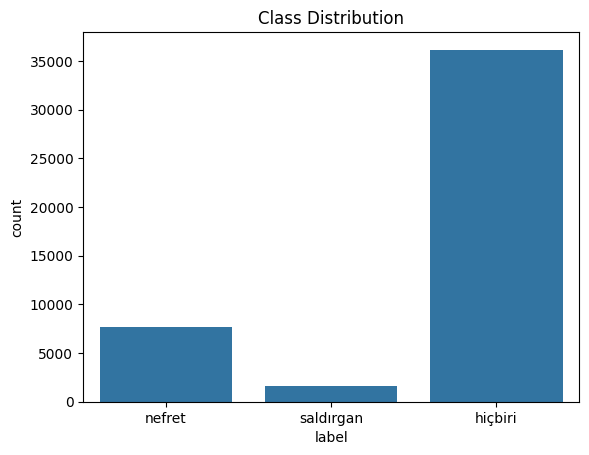

In [68]:
# show the label distrbution as plt bar chart
sns.countplot(x='label', data=df_merged)
plt.title('Class Distribution')
plt.show()

1. Oversampling: Increases the number of minority class samples.
- SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples for the minority class.
2. Undersampling: Decreases the number of majority class samples.
- RandomUnderSampler: Randomly removes samples from the majority class.
3. Combined Methods: Uses both oversampling and undersampling.
- SMOTEENN (SMOTE + Edited Nearest Neighbors): Combines SMOTE and undersampling.


In [73]:
# Separate features and target > X is the processed text, y is the encoded label
X = df_merged['processed_text']
y = df_merged['encoded_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Oversampling using SMOTE:

In [74]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

Undersampling using RandomUnderSampler

In [75]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_tfidf, y_train)

Combined Method using SMOTEENN

In [76]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=42)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train_tfidf, y_train)

Train and Evaluate Models

In [79]:
os.makedirs('performance_reports', exist_ok=True)

def train_and_evaluate(X_train, y_train, X_test, y_test, model_name):
    # setting estimators to 50 for faster training
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    
    # Save the report to a file
    report_filename = f'temp/imbalanced_{model_name}_report.pkl'
    with open(report_filename, 'wb') as f:
        pickle.dump(report, f)
    
    return f1_score, report

f1_scores = []

# train and evaluate on original data
f1_score_original, report_original = train_and_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 'original')
f1_scores.append({'Resampling Technique': 'Original', 'F1 Score': f1_score_original})

# train and evaluate on SMOTE data
f1_score_smote, report_smote = train_and_evaluate(X_train_smote, y_train_smote, X_test_tfidf, y_test, 'smote')
f1_scores.append({'Resampling Technique': 'SMOTE', 'F1 Score': f1_score_smote})

# train and evaluate on undersampled data
f1_score_under, report_under = train_and_evaluate(X_train_under, y_train_under, X_test_tfidf, y_test, 'undersampling')
f1_scores.append({'Resampling Technique': 'Undersampling', 'F1 Score': f1_score_under})

# train and evaluate on SMOTEENN data
f1_score_smote_enn, report_smote_enn = train_and_evaluate(X_train_smote_enn, y_train_smote_enn, X_test_tfidf, y_test, 'smoteenn')
f1_scores.append({'Resampling Technique': 'SMOTEENN', 'F1 Score': f1_score_smote_enn})

# save the F1 scores to a file
f1_scores_filename = 'temp/imbalanced_f1_scores.pkl'
with open(f1_scores_filename, 'wb') as f:
    pickle.dump(f1_scores, f)

In [80]:
# load imbalance F1 scores from pickle file
with open('temp/imbalanced_f1_scores.pkl', 'rb') as f:
    f1_scores = pickle.load(f)

# Convert the F1 scores to a DataFrame
df_f1_scores = pd.DataFrame(f1_scores)
print(df_f1_scores)

  Resampling Technique  F1 Score
0             Original  0.794034
1                SMOTE  0.799925
2        Undersampling  0.638848
3             SMOTEENN  0.167392
